# Dog and Cat Detection

This notebook explores using transfer learning to fine tune a torchvision object detection model to accurately detect cats and dogs in images.

Data obtained from:
https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection

https://debuggercafe.com/a-simple-pipeline-to-train-pytorch-faster-rcnn-object-detection-model/

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import PIL
from sklearn.model_selection import train_test_split
import time
import torch
import torchvision
import xml.etree.ElementTree as ET

try:
    from torch_snippets import Report
except:
    !pip install -q torch_snippets
    from torch_snippets import Report

# Connect to GPU is possible.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

print("Using {}.".format(device))

Using cuda.


# Download Data from Kaggle

https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection

In [3]:
if "kaggle.json" not in os.listdir("./"):
    initialize = True
else:
    initialize = False

if initialize == True:
    !pip install -q kaggle
    from google.colab import files
    files.upload()

if initialize == True:
    !mkdir ~/.kaggle

    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download 'andrewmvd/dog-and-cat-detection'
    !unzip -q dog-and-cat-detection.zip

# Prepare Datasets

In [4]:
label_dict = {"dog": 1, "cat" : 2}
reverse_label_dict = {1: "dog", 2: "cat"}

def xml_to_dict(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    return {"filename": xml_path, 
            "image_width": int(root.find("./size/width").text),
            "image_height": int(root.find("./size/height").text),
            "image_channels": int(root.find("./size/depth").text),
            "label": root.find("./object/name").text,
            "x1": int(root.find("./object/bndbox/xmin").text),
            "y1": int(root.find("./object/bndbox/ymin").text),
            "x2": int(root.find("./object/bndbox/xmax").text),
            "y2": int(root.find("./object/bndbox/ymax").text)}

class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
   
        self.files = sorted(os.listdir("images"))
        for i in range(len(self.files)):
            self.files[i] = self.files[i].split(".")[0]

        self.label_dict = label_dict

    def __getitem__(self, i):
        # Load image from disk.
        img = PIL.Image.open(os.path.join(self.root, "images/" + self.files[i] + ".png")).convert("RGB")
        # Load annotation file from disk.
        ann = xml_to_dict(os.path.join(self.root, "annotations/" + self.files[i] + ".xml"))

        target = {}

        target["boxes"] = torch.as_tensor([[ann["x1"], ann["y1"], ann["x2"], ann["y2"]]], dtype = torch.float32)
        target["labels"] = torch.as_tensor([self.label_dict[ann["label"]]], dtype = torch.int64)
        target["image_id"] = torch.as_tensor(i)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.files)

# Helper Functions

https://github.com/pytorch/vision/tree/v0.12.0/references/detection

### transforms.py

In [5]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(torch.nn.Module):
    def forward(self, image, target = None):
        image = torchvision.transforms.functional.pil_to_tensor(image)
        image = torchvision.transforms.functional.convert_image_dtype(image)
        return image, target

class RandomHorizontalFlip(torchvision.transforms.transforms.RandomHorizontalFlip):
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = torchvision.transforms.functional.hflip(image)
            if target is not None:
                width, _ = torchvision.transforms.functional.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
        return image, target

In [6]:
def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

## Prepare Datasets & Dataloaders

In [7]:
train_ds = CatDogDataset("./", get_transform(train = True))
val_ds = CatDogDataset("./", get_transform(train = False))
test_ds = CatDogDataset("./", get_transform(train = False))

indices = torch.randperm(len(train_ds)).tolist()

train_ds = torch.utils.data.Subset(train_ds, indices[:int(len(indices) * 0.64)])
val_ds = torch.utils.data.Subset(val_ds, indices[int(len(indices) * 0.64):int(len(indices) * 0.8)])
test_ds = torch.utils.data.Subset(test_ds, indices[int(len(indices) * 0.8):])

print(len(train_ds), len(val_ds), len(test_ds))

2359 589 738


In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 4, shuffle = True, collate_fn = collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = 4, shuffle = False, collate_fn = collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 4, shuffle = False, collate_fn = collate_fn)

print(len(train_dl), len(val_dl), len(test_dl))

590 148 185


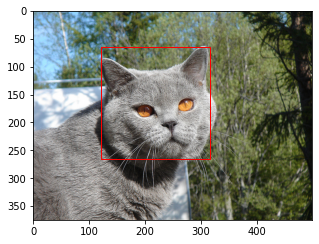

In [38]:
img_index = 3

image, target = train_ds[img_index]
boxes = target["boxes"]

fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(image.permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2], (b[2] - b[0]), (b[3] - b[1]), 
                             linewidth = 1, edgecolor = "r", facecolor = "none")
    ax.add_patch(rect)
plt.show()

# Build Model

In [9]:
def get_object_detection_model(num_classes = 2, feature_extraction = True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

    if feature_extraction == True:
        for p in model.parameters():
            p.requires_grad = False

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

# Train Model

In [10]:
def unbatch(batch, device):
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y

def train_batch(batch, model, optimizer, device):
    model.train()
    X, y = unbatch(batch, device = device)

    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()

    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optimizer, device):
    model.train() 
    X, y = unbatch(batch, device = device)

    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())

    return loss, losses

In [11]:
def train_fasterrcnn(model, optimizer, n_epochs, train_loader, test_loader = None, log = None, keys = None, device = "cpu"):
    if log is None:
        log = Report(n_epochs)
    
    if keys is None:
        keys = ["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]

    model.to(device)

    for epoch in range(n_epochs):
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses = train_batch(batch, model, optimizer, device)
            loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in keys]
            pos = (epoch + (ix + 1) / N)
            log.record(pos = pos, trn_loss = loss.item(), end = "\r")

        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                loss, losses = validate_batch(batch, model, optimizer, device)
                loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in keys]
                pos = (epoch + (ix + 1) / N)
                log.record(pos = pos, val_loss = loss.item(), end = "\r")

    log.report_avgs(epoch + 1)

    return log

In [12]:
model = get_object_detection_model(num_classes = len(label_dict) + 1, feature_extraction = False)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [14]:
start_time = time.time()
log = train_fasterrcnn(model = model, optimizer = optimizer, n_epochs = 1, 
                       train_loader = train_dl, test_loader = val_dl, 
                       log = None, keys = None, 
                       device = device)
end_time = time.time()
print(end_time - start_time)

EPOCH: 1.000	trn_loss: 0.119	val_loss: 0.080	(938.16s - 0.00s remaining)
938.1591229438782


In [15]:
images = []
targets = []
for im, tg in test_dl:
    images = images + [i for i in im]
    targets = targets + [{k: v for k, v in t.items()} for t in tg]
print(len(images), len(targets))

738 738


In [16]:
@torch.no_grad()
def predict_batch(batch, model, device):
    model.to(device)
    model.eval()
    X, _ = unbatch(batch, device = device)

    predictions = model(X)

    return predictions

def predict(model, data_loader, device = "cpu"):
    predictions = []
    for i, batch in enumerate(data_loader):
        predictions = predictions + predict_batch(batch, model, device)
    return predictions

def decode_prediction(prediction, score_threshold = 0.8, nms_iou_threshold = 0.2):
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]

    if score_threshold is not None:
        want = scores > score_threshold
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]

    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes = boxes, scores = scores, iou_threshold = nms_iou_threshold)
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]

    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

In [17]:
predictions = predict(model, test_dl, device)

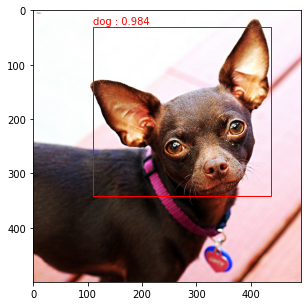

In [18]:
img_index = 1
boxes, labels, scores = decode_prediction(predictions[img_index])

fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).detach().numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int), (b[2] - b[0]).astype(int), (b[3] - b[1]).astype(int), 
                             linewidth = 1, edgecolor = "r", facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int), b[1].astype(int) - 5, "{} : {:.3f}".format(reverse_label_dict[labels[i]], scores[i]), color = "r")
plt.show()